In [1]:
# Enable automatic cell execution time for JupyterLab version < 2.0.2

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 59.1 µs (started: 2025-08-03 23:40:57 +00:00)


In [2]:
# For RACE only (run only the first time you execute the Jupyter Notebook)
!pip install einops==0.6.0
!pip install ema-pytorch==0.2.1

# For DiffSTG:
!pip install tables==3.9.2
#!pip install widgetsnbextension

!pip install jupyterlab_widgets==1.1.1
!pip install ipywidgets==7.6.6

!pip install nni==3.0
!pip install easydict==1.13

time: 6.89 s (started: 2025-08-03 23:40:59 +00:00)


In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

project_root = os.path.abspath('.') # Assuming notebook is in the root
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the necessary functions from the train.py script
try:
    from train_128_bodysys25_0825 import main as run_diffstg_training
    from train_128_bodysys25_0825 import get_params
except ImportError as e:
    print(f"Error importing from train.py: {e}")
    print("Make sure train.py is in the same directory as this notebook or in the Python path.")

print("Functions imported successfully.")

Functions imported successfully.
time: 2.11 s (started: 2025-08-03 23:41:07 +00:00)


In [4]:
# Get the default parameters as defined in get_params()
default_args = get_params()

# Convert the Namespace object to a dictionary
params = vars(default_args)

params['data'] = 'HAR'          # Dataset name
params['is_train'] = True       # Set to True to train, False for evaluation only
params['is_test'] = False       # Set to True for quick test runs

# Model parameters
params['epsilon_theta'] = 'UGnet'
params['hidden_size'] = 32
params['N'] = 200               # Diffusion timesteps for training definition
params['beta_schedule'] = 'quad'
params['beta_end'] = 0.1        # Or your desired value (default_config might override this)
params['sample_steps'] = 200    # Default sample steps for the model object, can be overridden
params['ss'] = 'ddpm'           # Default sampling strategy for the model object

# Training parameters
params['T_h'] = 128             # History length / Window length for HAR
params['lr'] = 0.002            # Learning rate

params['batch_size'] = 16        # Batch size for RACE
#params['batch_size'] = 4        # Batch size for local

params['n_samples'] = 8         # Number of samples for validation (evals sets this to 1 if mode=='validation')

# NNI specific flag - not used when running directly, so can be default or ignored by main
params['nni'] = False

print("Parameters configured:")
for key, value in params.items():
    print(f"  {key}: {value}")

Parameters configured:
  epsilon_theta: UGnet
  hidden_size: 32
  N: 200
  beta_schedule: quad
  beta_end: 0.1
  sample_steps: 200
  ss: ddpm
  T_h: 128
  n_samples: 8
  is_train: True
  data: HAR
  mask_ratio: 0.0
  is_test: False
  nni: False
  lr: 0.002
  batch_size: 16
time: 2.11 ms (started: 2025-08-03 23:41:11 +00:00)


In [ ]:
# Start training the model
print("\nStarting DiffSTG training from Jupyter Notebook...")
try:
    # Call the main function from train.py
    run_diffstg_training(params)
    print("Training finished successfully.")
except Exception as e:
    print(f"An error occurred during training: {e}")
    import traceback
    traceback.print_exc() # Prints the full traceback for debugging


Starting DiffSTG training from Jupyter Notebook...
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): NVIDIA A10G
{'PATH_IMPUTATION': '/home/ec2-user/SageMaker/output/HAR_forearm/imputations/',
 'PATH_LOG': '/home/ec2-user/SageMaker/output/HAR_forearm/log/',
 'PATH_MOD': '/home/ec2-user/SageMaker/output/HAR_forearm/model/',
 'T_h': 128,
 'T_p': 0,
 'batch_size': 16,
 'data': {'feature_file': '/home/ec2-user/SageMaker/data/dataset/HAR/raw_train_data_forearm.npy',
          'name': 'HAR',
          'num_features': 3,
          'num_recent': 1,
          'num_vertices': 7,
          'path': '/home/ec2-user/SageMaker/data/dataset/',
          'spatial': '/home/ec2-user/SageMaker/data/dataset/HAR/adj.npy'},
 'device': device(type='cuda'),
 'early_stop': 5,
 'epoch': 20,
 'evaluation': {'val_sample_steps': 20, 'val_sample_strategy': 'ddim_multi'},
 'is_test': False,
 'log_path': '/home/ec2-user/SageMaker/output/HAR_fore

In [7]:
# Load the .npy file
#gt_thigh = np.load('./output/HAR_forearm/imputations/gt_thigh.npy')
#pred_thigh = np.load('./output/HAR_forearm/imputations/pred_thigh.npy')
#gt_thigh = np.load('./output/HAR_forearm/imputations/gt_forearm.npy')
#pred_thigh = np.load('./output/HAR_forearm/imputations/pred_forearm.npy')
gt_thigh = np.load('./output/HAR_forearm/imputations/gt_target_sensor.npy')
pred_thigh = np.load('./output/HAR_forearm/imputations/pred_mean_target_sensor.npy')

print(gt_thigh.shape)
#print(gt_thigh)
print(pred_thigh.shape)
#print(pred_thigh)

(28665, 128, 3)
(28665, 128, 3)
time: 18.6 ms (started: 2025-08-05 14:57:13 +00:00)


<Figure size 640x480 with 0 Axes>

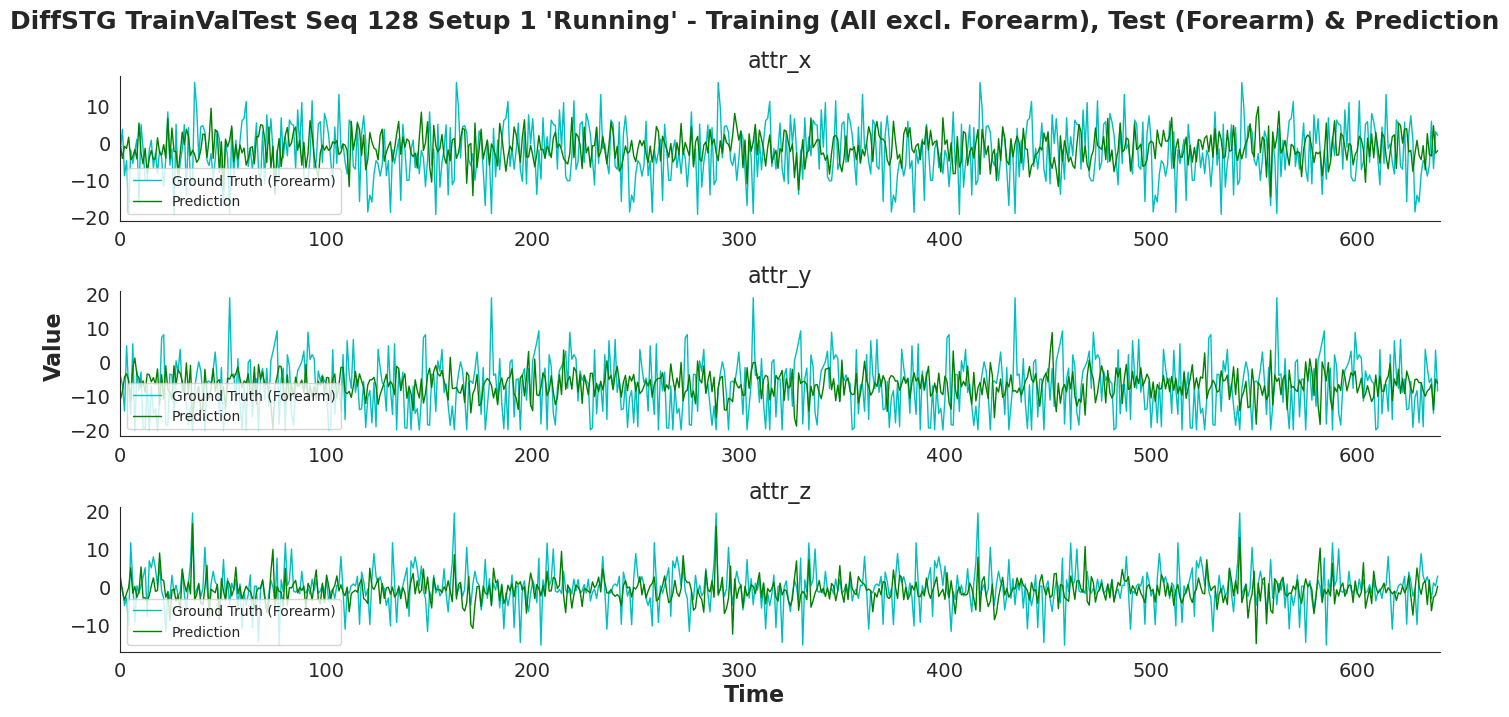

time: 1.01 s (started: 2025-08-05 14:57:59 +00:00)


In [9]:
cv_iteration = 1

# Set the tickers for the values
tickers = ['attr_x', 'attr_y', 'attr_z']

# Plot and compare the original time series with the synthetic generated one
sns.set_style('white')
sns.despine()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 7))
axes = axes.flatten()

#the_indexes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
the_indexes = [0,1,2,3,4]
#synthetic = list(sample[the_indexes])
synthetic = list(pred_thigh[the_indexes])
# print(type(synthetic))
#synthetic = np.array(synthetic).reshape(600, 3)
synthetic = np.array(synthetic).reshape(640, 3)
#synthetic = np.array(synthetic).reshape(840, 3)
# print(type(synthetic))

#ground_truth = list(real_testing_split_test[the_indexes])
ground_truth = list(gt_thigh[the_indexes])
#ground_truth = np.array(ground_truth).reshape(600, 3)
ground_truth = np.array(ground_truth).reshape(640, 3)
#ground_truth = np.array(ground_truth).reshape(840, 3)

#training_truth = list(real_training_split_test[the_indexes])
#training_truth = list(final_arr_train_unn[the_indexes])
#training_truth = np.array(training_truth).reshape(600, 3)
#training_truth = np.array(training_truth).reshape(840, 3)

for j, ticker in enumerate(tickers):
    (pd.DataFrame({
        'Ground Truth (Forearm)': ground_truth[:, j],
        #'Training (All excl. Thigh)': training_truth[:, j],
        'Prediction': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker, fontsize=14, xlim=(0,640), color=[ "c", "g", "r" ],
           lw=1).set_title(ticker, fontdict={'fontsize': 16}))

# iterate through each axes to use axes level methods
for ax in axes:
    ax.legend(loc='lower left')

sns.despine()
fig.suptitle('DiffSTG TrainValTest Seq 128 Setup ' + str(cv_iteration) + ' \'Running\' - Training (All excl. Forearm), Test (Forearm) & Prediction', fontsize=18, weight='bold')

# Set common labels
#fig.text(0.5, 0.0, '# of data point', ha='center', va='center', fontsize=16, weight='bold')
fig.text(0.5, 0.0, 'Time', ha='center', va='center', fontsize=16, weight='bold')
fig.text(0.0, 0.5, 'Value', ha='center', va='center', rotation='vertical', fontsize=16, weight='bold')
fig.tight_layout()

# Save figure as SVG and PNG
figure_filename_svg = 'diffstg_CVI' + str(cv_iteration) + '_all_forearm_synthetic_data_sequence1to25_seqlen_128_window_128_V1.svg'
figure_filename_png = 'diffstg_CVI' + str(cv_iteration) + '_all_forearm_synthetic_data_sequence1to25_seqlen_128_window_128_V1.png'

out_dir = './output/HAR_forearm/plots/'
#out_dir = './output/HAR_thigh/plots/'

fig.savefig(os.path.join(out_dir, f'diffstg_bodysys25_CVI' + str(cv_iteration) + '_all_forearm_synthetic_data_sequence1to5_seqlen_128_window_128_V1.svg'), bbox_inches='tight')
fig.savefig(os.path.join(out_dir, f'diffstg_bodysys25_CVI' + str(cv_iteration) + '_all_forearm_synthetic_data_sequence1to5_seqlen_128_window_128_V1.png'), bbox_inches='tight')

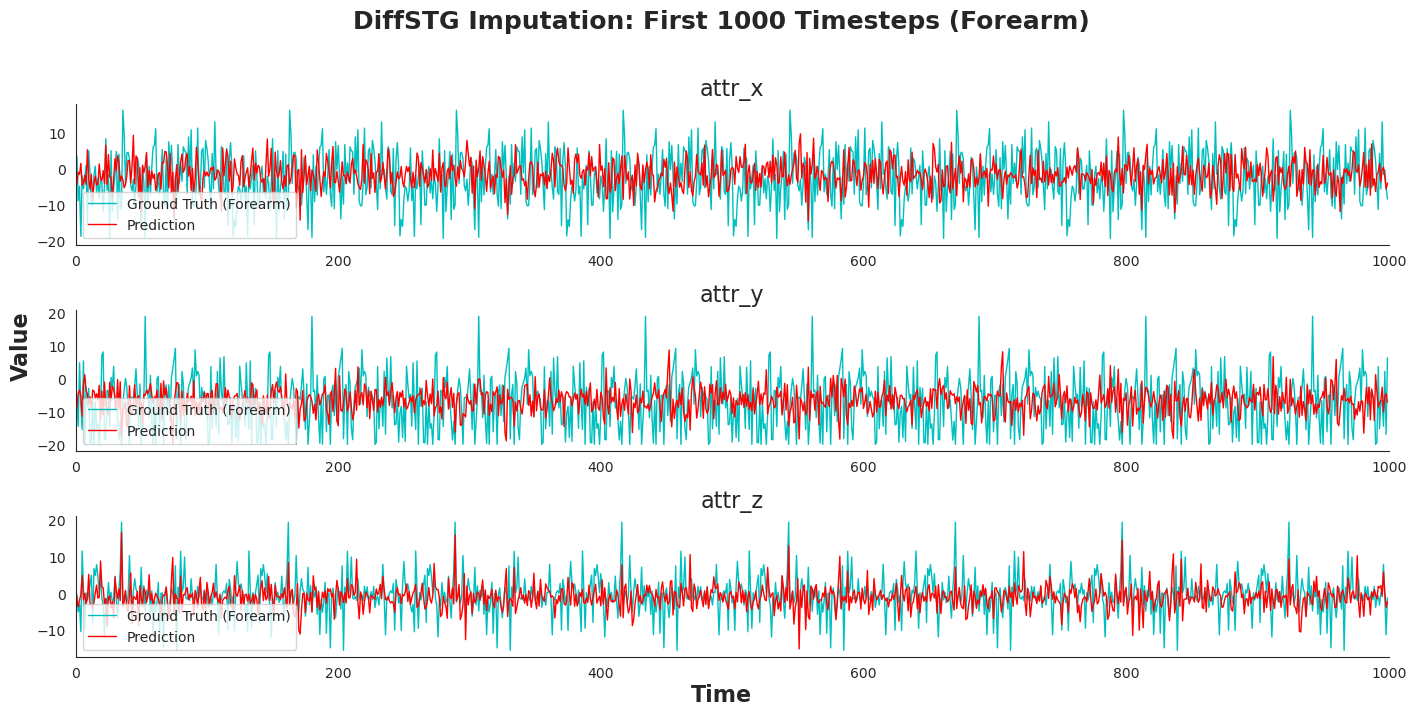

time: 459 ms (started: 2025-08-05 15:00:45 +00:00)


In [10]:
# Flatten all windows (concatenate along time)
synthetic_flat = pred_thigh.reshape(-1, 3)
ground_truth_flat = gt_thigh.reshape(-1, 3)
# Select the first 1000 time steps for plotting
n_plot = 1000
cv_iteration = 1

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 7))
axes = axes.flatten()
tickers = ['attr_x', 'attr_y', 'attr_z']

for j, ticker in enumerate(tickers):
    axes[j].plot(ground_truth_flat[:n_plot, j], label='Ground Truth (Forearm)', color='c', lw=1)
    axes[j].plot(synthetic_flat[:n_plot, j], label='Prediction', color='r', lw=1)
    axes[j].set_title(ticker, fontsize=16)
    axes[j].legend(loc='lower left')
    axes[j].set_xlim(0, n_plot)

fig.suptitle('DiffSTG Imputation: First 1000 Timesteps (Forearm)', fontsize=18, weight='bold')
fig.text(0.5, 0.0, 'Time', ha='center', va='center', fontsize=16, weight='bold')
fig.text(0.0, 0.5, 'Value', ha='center', va='center', rotation='vertical', fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.96])
sns.despine()
plt.show()

In [11]:
# Load all necessary data
#gt_all_windows = np.load('./output/HAR/imputations/gt_thigh.npy') # Shape (28769, 24, 3)
#mean_pred_all_windows = np.load('./output/HAR/imputations/pred_thigh.npy') # Shape (28769, 24, 3)
#gt_all_windows = np.load('./output/HAR_forearm/imputations/gt_forearm.npy') # Shape (28769, 24, 3)
#mean_pred_all_windows = np.load('./output/HAR_forearm/imputations/pred_forearm.npy') # Shape (28769, 24, 3)
gt_all_windows = np.load('./output/HAR_forearm/imputations/gt_target_sensor.npy') # Shape (28769, 24, 3)
mean_pred_all_windows = np.load('./output/HAR_forearm/imputations/pred_mean_target_sensor.npy') # Shape (28769, 24, 3)

# Load the individual samples (which are only for the first batch)
individual_samples_first_batch = np.load('./output/HAR_forearm/imputations/pred_samples_target_sensor.npy')

# Select data for the specific window to plot
window_index_overall = 0 # This is the index into the full test set

# Get GT and Mean Prediction for this window
gt_for_plotting = gt_all_windows[window_index_overall, :, :] # Shape (24, 3)
mean_pred_for_plotting = mean_pred_all_windows[window_index_overall, :, :] # Shape (24, 3)

# Get individual samples for this window (it's index 0 within the first batch)
if window_index_overall < individual_samples_first_batch.shape[0]: # Check if it's part of the saved batch
    sample_1_for_plotting = individual_samples_first_batch[window_index_overall, 0, :, :] # 1st sample (index 0)
    sample_4_for_plotting = individual_samples_first_batch[window_index_overall, 3, :, :] # 4th sample (index 3)
    sample_8_for_plotting = individual_samples_first_batch[window_index_overall, 7, :, :] # 8th sample (index 7)
else:
    print(f"Window index {window_index_overall} is not in the first batch for which individual samples were saved.")

time: 115 ms (started: 2025-08-05 15:00:55 +00:00)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_imputation_comparison_with_individual_samples(
    gt_all_windows,
    mean_pred_all_windows,
    individual_samples_first_batch,
    window_index_to_plot=0,
    sample_indices_to_plot=[0, 3, 7] # Corresponds to Sample 1, Sample 4, Sample 8
    #sample_indices_to_plot=[0, 1, 2, 3, 4, 5, 6, 7] # Corresponds to all samples
    ):
    """
    Plots the ground truth, mean prediction, and selected individual samples
    for a specific window from the test set.

    Args:
        gt_all_windows (np.ndarray): Ground truth array of shape (N_total_windows, T_h, F).
        mean_pred_all_windows (np.ndarray): Mean prediction array of shape (N_total_windows, T_h, F).
        individual_samples_first_batch (np.ndarray): Individual samples saved for the first batch.
                                                    Shape (B_test, S_samples, T_h, F).
        window_index_to_plot (int): The overall index (from 0 to N_total_windows-1)
                                     of the window to plot. Must be within the first batch.
        sample_indices_to_plot (list of int): 0-indexed list of which individual samples to plot
                                              from the S_samples dimension.
    """

    # Ensure the chosen window_index_to_plot is part of the first batch for which
    # individual samples were saved
    num_windows_in_first_batch = individual_samples_first_batch.shape[0]
    if window_index_to_plot >= num_windows_in_first_batch:
        print(f"Error: Window index {window_index_to_plot} is outside the range of the first batch "
              f"(0 to {num_windows_in_first_batch - 1}) for which individual samples were saved.")
        return

    # Ground Truth for the selected window
    gt_single_window = gt_all_windows[window_index_to_plot, :, :]  # Shape: (T_h, F), e.g., (24, 3)

    # Mean Prediction for the selected window
    mean_pred_single_window = mean_pred_all_windows[window_index_to_plot, :, :] # Shape: (T_h, F)

    # Individual Samples for the selected window
    selected_individual_samples = []
    num_available_samples = individual_samples_first_batch.shape[1] # S_samples
    for s_idx in sample_indices_to_plot:
        if s_idx < num_available_samples:
            selected_individual_samples.append(
                individual_samples_first_batch[window_index_to_plot, s_idx, :, :] # Shape: (T_h, F)
            )
        else:
            print(f"Warning: Requested sample index {s_idx} (Sample {s_idx+1}) is out of bounds for plotting. "
                  f"Only {num_available_samples} samples are available in the file.")
            selected_individual_samples.append(None) # Add a placeholder

    num_timesteps = gt_single_window.shape[0]
    num_features = gt_single_window.shape[1]
    timesteps_axis = np.arange(num_timesteps)
    feature_names = ['X-axis', 'Y-axis', 'Z-axis']

    sns.set_style('whitegrid')
    fig, axs = plt.subplots(num_features, 1, figsize=(18, 6 * num_features), sharex=True)
    if num_features == 1:
        axs = [axs]

    colors = plt.cm.viridis(np.linspace(0, 0.7, len(sample_indices_to_plot))) # Colors for individual samples

    for i in range(num_features):
        # Plot Ground Truth
        axs[i].plot(timesteps_axis, gt_single_window[:, i],
                    label='Ground Truth', color='black', linewidth=2.5, zorder=10)

        # Plot Mean Prediction
        axs[i].plot(timesteps_axis, mean_pred_single_window[:, i],
                    label='Mean Prediction (of 8 samples)', color='red', linestyle='--', linewidth=2, zorder=9)

        # Plot Selected Individual Samples
        for k, s_idx in enumerate(sample_indices_to_plot):
            if selected_individual_samples[k] is not None:
                axs[i].plot(timesteps_axis, selected_individual_samples[k][:, i],
                            label=f'Sample {s_idx+1}', color=colors[k], alpha=0.6, linewidth=1.5, zorder=k+1)

        axs[i].set_ylabel(f'{feature_names[i]} Value')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

    axs[-1].set_xlabel('Time Step within Window')
    fig.suptitle(f'DiffSTG Imputation: Ground Truth vs. Mean vs. Individual Samples (Forearm Sensor - Window {window_index_to_plot})',
                 fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    sns.despine()
    plt.show()

    out_dir = './output/HAR_forearm/plots/'

    fig.savefig(os.path.join(out_dir, f'diffstg_CVI' + str(cv_iteration) + '_all_forearm_synthetic_data_gt_pred_samples_all_seqlen_128_window_1_V1.svg'), bbox_inches='tight')
    fig.savefig(os.path.join(out_dir, f'diffstg_CVI' + str(cv_iteration) + '_all_forearm_synthetic_data_gt_pred_samples_all_seqlen_128_window_1_V1.png'), bbox_inches='tight')

time: 2.62 ms (started: 2025-08-05 15:01:05 +00:00)


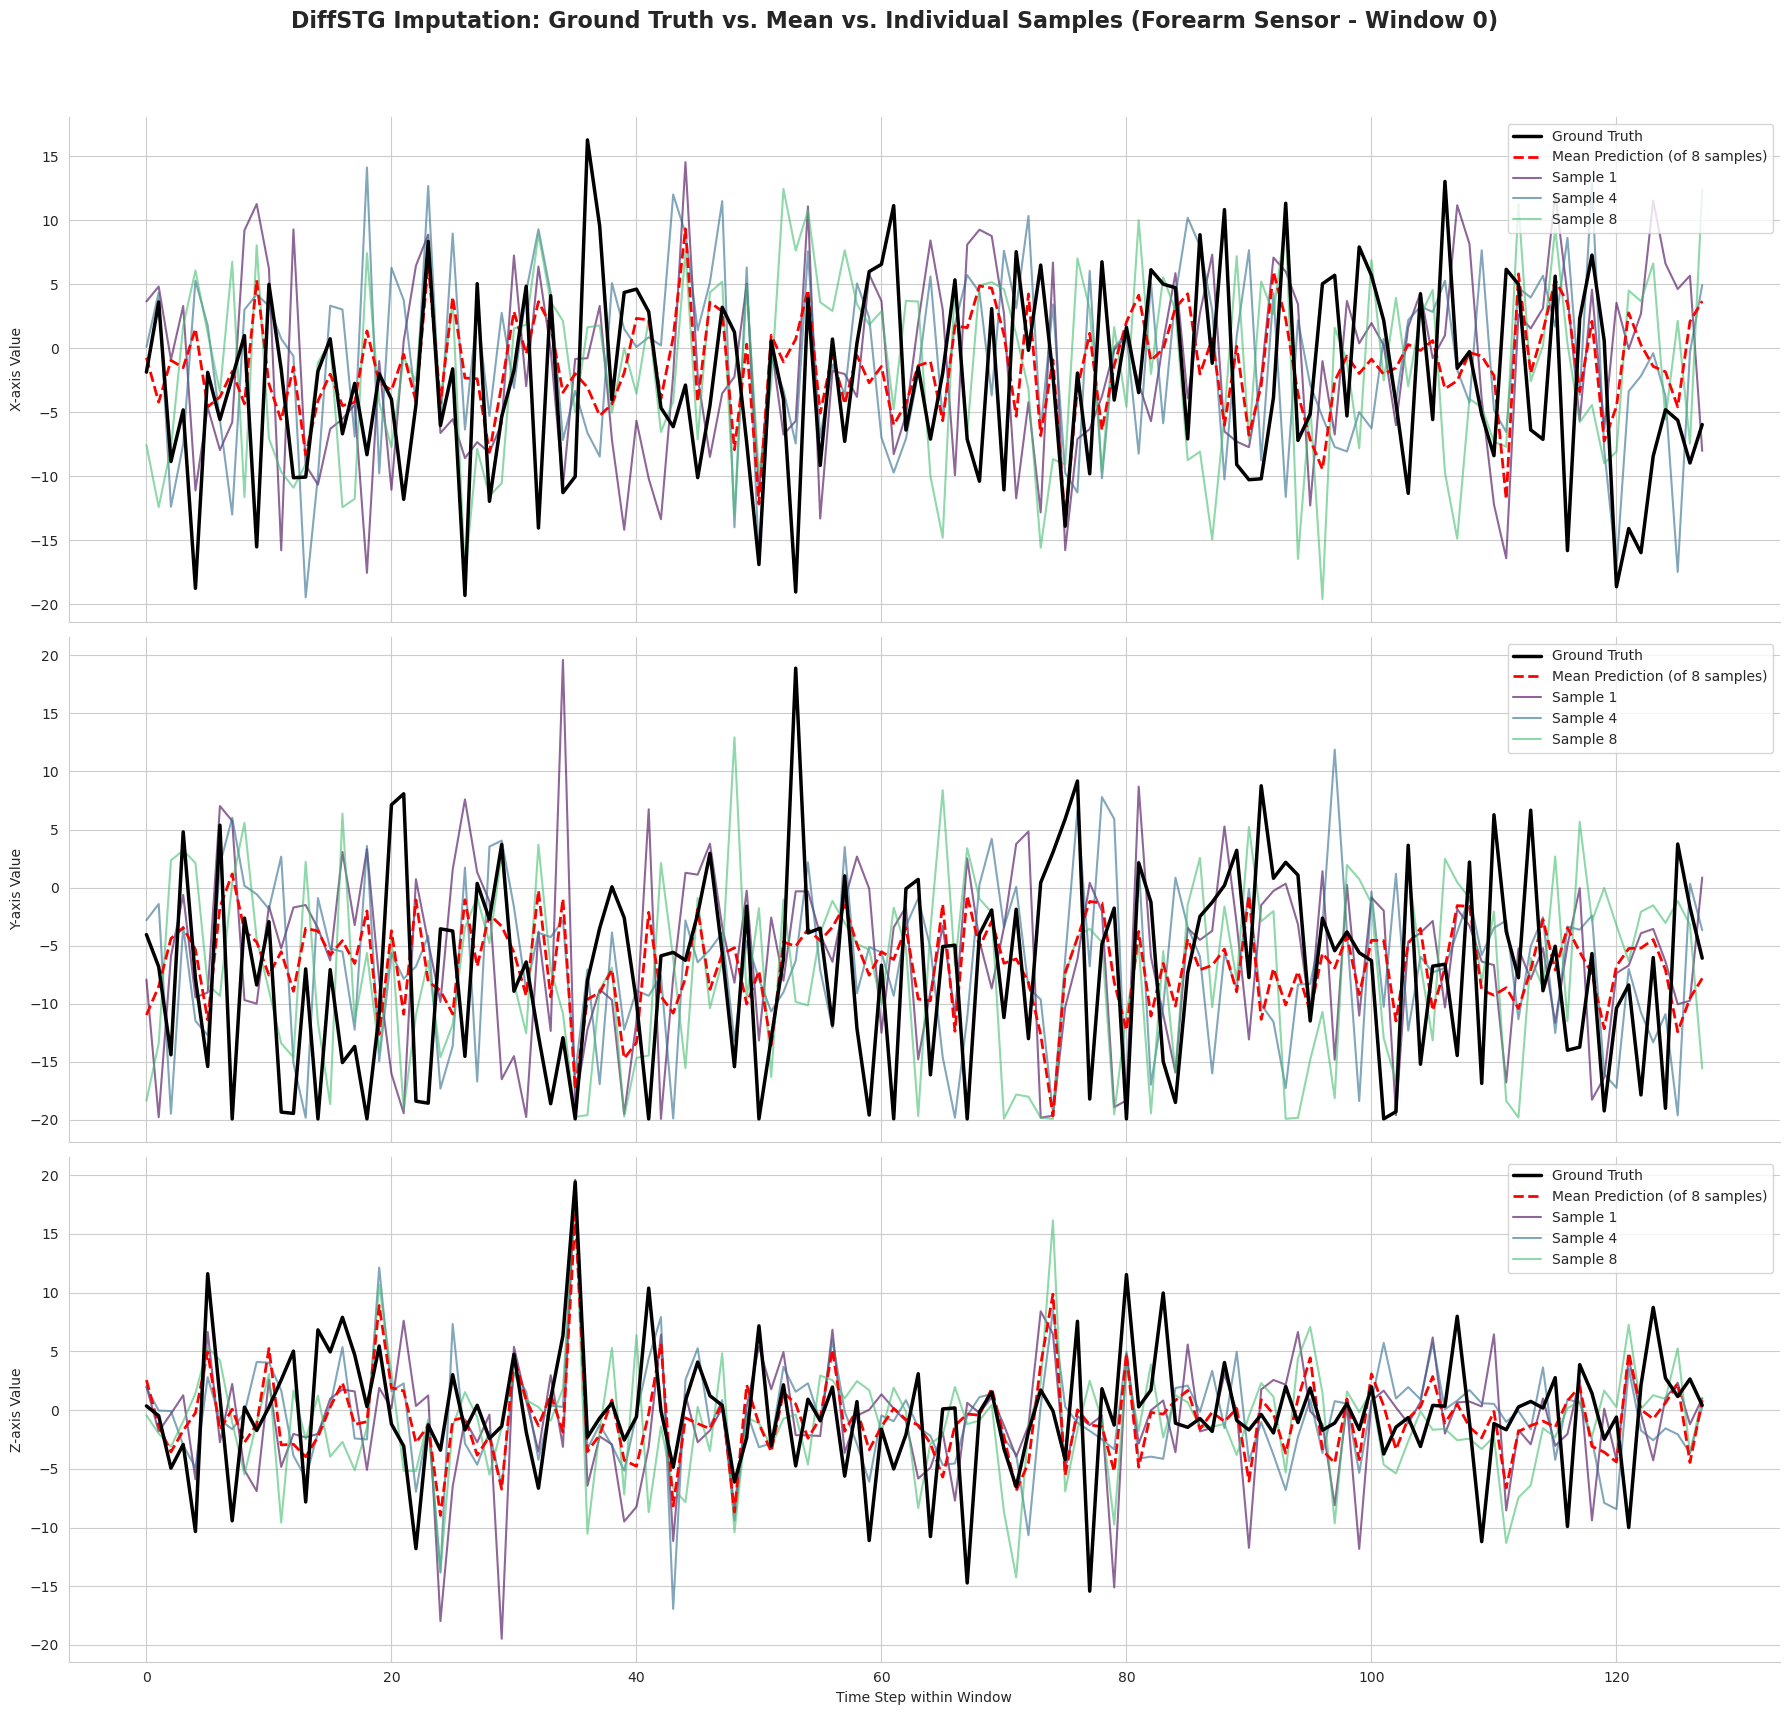

time: 1.21 s (started: 2025-08-05 15:01:09 +00:00)


In [13]:
plot_imputation_comparison_with_individual_samples(
         gt_all_windows,
         mean_pred_all_windows,
         individual_samples_first_batch,
         window_index_to_plot=0 # Plot the first window from the batch
     )